# Script to train vector representations of words in tensorflow
-------------------------------------------------------------------------------------------------------------------
# Reference: https://www.tensorflow.org/tutorials/word2vec

In [1]:
"""Basic word2vec example."""
# required imports:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

In [114]:
""" Important constants and paths """
# paths:

# constants:
download_url = 'http://mattmahoney.net/dc/'
vocabulary_size = 200000
data_index = 0

In [7]:
""" function to download the dataset """
def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urllib.request.urlretrieve(download_url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    print(statinfo.st_size)
    raise Exception(
        'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

In [11]:
# downlaod the file in the datafolder
filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [26]:
# Read the data into a list of strings.
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words."""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data

In [57]:
raw_data_sequence = read_data(filename)
print('Data size', len(raw_data_sequence))

Data size 17005207


In [42]:
def build_dataset(words, n_words):
  """Process raw inputs into a dataset."""
  count = [['UNK', -1]] # start with this list.
  count.extend(collections.Counter(words).most_common(n_words - 1)) # this is inplace. i.e. has a side effect
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count # replace the earlier -1 by the so calculated unknown count

  print("Total rare words replaced: ", unk_count)
  
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary

In [43]:
data, count, dictionary, reverse_dictionary = build_dataset(raw_data_sequence, vocabulary_size)

Total rare words replaced:  53855


In [44]:
# display a few elements from all these variables:
print("\ndata              : ", data[:10])
print("\ncount             : ", count[:10])
print("\ndictionary        : ", list(zip(dictionary.keys()[:10], dictionary.values()[:10])))
print("\nreverse_dictionary: ", list(zip(reverse_dictionary.keys()[:10], reverse_dictionary.values()[:10])))


data              :  [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]

count             :  [['UNK', 53855], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430)]

dictionary        :  [('biennials', 82297), ('tripolitan', 100039), ('mdbg', 135336), ('vang', 58113), ('nunnery', 36075), ('sowell', 40562), ('utnapishtim', 135338), ('brownpride', 135339), ('fleeces', 154719), ('woods', 6263)]

reverse_dictionary:  [(0, 'UNK'), (1, 'the'), (2, 'of'), (3, 'and'), (4, 'one'), (5, 'in'), (6, 'a'), (7, 'to'), (8, 'zero'), (9, 'nine')]


In [58]:
del raw_data_sequence # Hint to reduce memory.

In [59]:
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 53855], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [128]:
# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, skip_window, num_skips=2*skip_window):
    global data_index

    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window

    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  
    buffer = collections.deque(maxlen=span)
    
    # if the data length is reached, rollover the data
    if data_index + span > len(data):
        data_index = 0
  
    buffer.extend(data[data_index:data_index + span])
  
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        if data_index == len(data):
            buffer[:] = data[:span]
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
  
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [129]:
print([reverse_dictionary[i] for i in data[:20]])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english']


In [130]:
print(data[:20])

[5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156, 128, 742, 477, 10572, 134, 1, 27549, 2, 1, 103]


In [131]:
batch, labels = generate_batch(batch_size=8, skip_window=1graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

  # Construct the SGD optimizer using a learning rate of 1.0.
  optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True))

SyntaxError: invalid syntax (<ipython-input-131-b5bc43543387>, line 1)

In [132]:
data[data_index - 8: data_index], batch, labels

([327, 7, 8469, 1, 1714, 15, 10530, 5],
 array([   2,    2, 3137, 3137,   46,   46,   59,   59], dtype=int32),
 array([[ 195],
        [3137],
        [   2],
        [  46],
        [  59],
        [3137],
        [  46],
        [ 156]], dtype=int32))

In [133]:
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],'->', labels[i, 0], reverse_dictionary[labels[i, 0]])

2 of -> 195 term
2 of -> 3137 abuse
3137 abuse -> 2 of
3137 abuse -> 46 first
46 first -> 59 used
46 first -> 3137 abuse
59 used -> 46 first
59 used -> 156 against


# Hyper parameters for the training:

In [134]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

In [135]:
# reset the data_index:
data_index = 0

In [136]:
graph = tf.Graph()

with graph.as_default():

    # Input data.
    with tf.variable_scope("Input_Placeholders"):
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size], name="input")
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1], name="labels")
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32, name="validation_input")

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        with tf.variable_scope("Learnable_parameters"):
            # Look up embeddings for inputs.
            embeddings = tf.Variable(
                tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name="final_embeddings")

            embed = tf.nn.embedding_lookup(embeddings, train_inputs, name="lookuped_embeddings")

            # Construct the variables for the NCE loss
            nce_weights = tf.Variable(
                tf.truncated_normal([vocabulary_size, embedding_size],
                                    stddev=1.0 / math.sqrt(embedding_size)), name="weights")

            nce_biases = tf.Variable(tf.zeros([vocabulary_size]), name="biases")

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    with tf.variable_scope("NCE_Loss"):
        loss = tf.reduce_mean(
            tf.nn.nce_loss(weights=nce_weights,
                            biases=nce_biases,
                            labels=train_labels,
                            inputs=embed,
                            num_sampled=num_sampled,
                            num_classes=vocabulary_size), name="Loss")

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    with tf.variable_scope("Evaluation"):
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
        normalized_embeddings = embeddings / norm
        valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
        similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [137]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  # We must initialize all variables before we use them.
  session.run(tf.global_variables_initializer())
  print('Initialized')

  # graph visualizer:
  tensorboard_writer = tf.summary.FileWriter("../Models/Model1/", graph=session.graph)

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  348.877532959
Nearest to zero: alliances, stenography, eboracensis, hirpini, myoglobin, gaskets, citicorp, aldermen,
Nearest to time: obstetrics, kufra, livestock, geminal, shotshells, rubinstein, vigd, consumerism,
Nearest to system: basename, soldek, brossa, cytoskeleton, navakar, vstr, qina, shit,
Nearest to an: minorities, largescale, masque, glean, geena, ardabur, mathbb, quietus,
Nearest to see: neshka, mylae, predicated, brehme, scamozzi, fauns, salcedo, mythologists,
Nearest to history: lutetia, grof, uzzah, mortimore, tradionally, orledge, canard, pensiero,
Nearest to over: softail, barset, waterweg, unshaven, mucor, parcon, mtp, aacis,
Nearest to while: criers, mulisch, chronotropic, querer, kenyon, seimu, chapitre, ruhr,
Nearest to this: lard, capuchins, verbrannt, humanities, tanna, indigointuition, foucauld, stocker,
Nearest to united: burgled, harding, acousitics, serra, tunicates, pristinus, animalympics, jab,
Nearest to at: orangis

Nearest to other: many, are, tamarin, abandonware, these, three, aspirin, and,
Nearest to called: accumulator, abet, annexation, baldrick, s, burns, but, cyg,
Nearest to from: and, in, or, eight, crb, with, five, six,
Nearest to if: archangel, that, abet, crb, with, tamarin, four, exert,
Nearest to i: tamarin, practitioners, glover, and, never, agreement, you, mark,
Average loss at step  52000 :  13.6500356792
Average loss at step  54000 :  13.4857287364
Average loss at step  56000 :  12.8961772981
Average loss at step  58000 :  12.1393410634
Average loss at step  60000 :  12.0642135892
Nearest to zero: five, eight, four, two, seven, six, three, nine,
Nearest to time: vma, livestock, quebec, undisputed, championships, ada, abet, agouti,
Nearest to system: with, abet, mesoplodon, cytoskeleton, leading, through, four, and,
Nearest to an: a, the, this, abet, it, jhana, another, one,
Nearest to see: abet, but, and, eight, is, of, in, four,
Nearest to history: abet, mesoplodon, number, circ

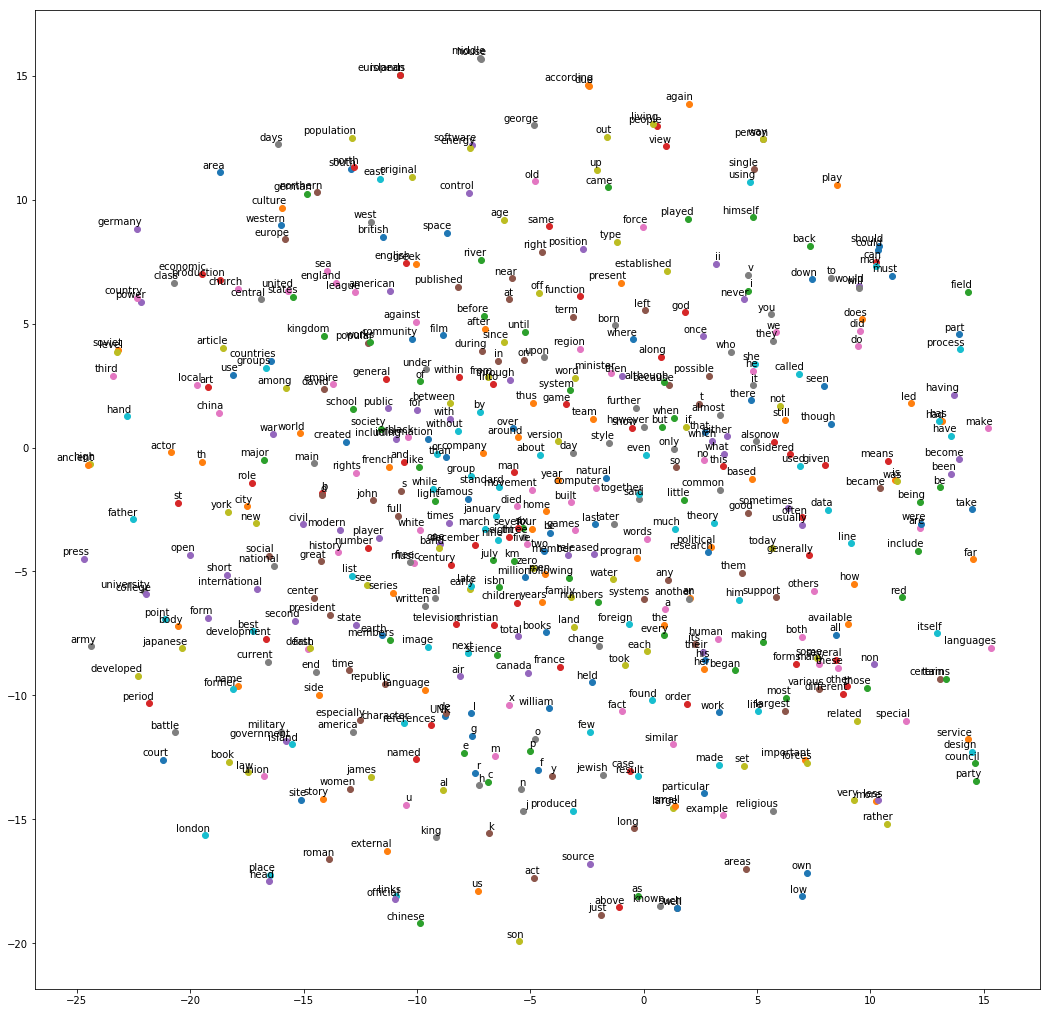

In [140]:
# plot the vector tsne of the learnt embeddings:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.savefig(filename)

try:
  # pylint: disable=g-import-not-at-top
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  %matplotlib inline

  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels)

except ImportError:
  print('Please install sklearn, matplotlib, and scipy to show embeddings.')